# k-NN using scikit-surprise

In [1]:
import helpers
from surprise_helpers import CustomReader, get_ratings_from_predictions
from surprise import Reader, Dataset

## Data loading
We load the data using our custom reader.
See: http://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset

In [2]:
reader = CustomReader()
filepath = helpers.get_train_file_path()
data = Dataset.load_from_file(filepath, reader=reader)

## Parameter search
We search for good values of parameters of the chosen algorithm.

First we need to define the search space.

In [25]:
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import RandomizedSearchCV
import pandas as pd

algos = [
    (KNNBasic, 'KNNBasic'),
    (KNNWithMeans, 'KNNBasic'),
    (KNNWithZScore, 'KNNWithZScore'),
    (KNNBaseline, 'KNNBaseline')
]   
param_grid = {
    'k': stats.randint(10,80),
    'min_k': stats.randint(1, 9),
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
        'user_based': [False, True],
        'min_support': [1, 10],
        'shrinkage': [0, 100]
    },
    'bsl_options': {
        'method': ['als'],
        'n_epochs': stats.randint(10, 15),
        'reg_i': stats.randint(8, 12),
        'reg_u': stats.randint(12, 18)
    }
}


We loop through all algo types:

In [26]:
def fit_and_store(algos):
    best_algos = []
    for algo, algo_name in algos:
        rs = RandomizedSearchCV(algo,
                                param_grid,
                                n_iter=25,
                                measures=['rmse'], cv=5, n_jobs=-1,
                                refit=True # so we can use test() directly
                                )

        rs.fit(data)
        timestamp = time.now()
        print('Best score {} with parameters:'.format(rs.best_score['rmse']))
        best_params_df = pd.DataFrame.from_dict(rs.best_params['rmse'])
        best_params_df.to_pickle('{}_best_params_{}.pkl'.format(algo_name))
        results_df = pd.DataFrame.from_dict(rs.cv_results)
        results_df.to_pickle('{}_results_{}.pkl')
        res.append((rs, algoname, timestamp))
    return best_algos

In [ ]:
best_algos = fit_and_store(algos)

## Predicting
We load the test data to predict.

In [20]:
test_file_path = helpers.get_test_file_path()
test_data = Dataset.load_from_file(test_file_path, reader=reader)
testset = test_data.construct_testset(test_data.raw_ratings)

Prediction(uid=36, iid=0, r_ui=3.0, est=3.1668749043413382, details={'actual_k': 35, 'was_impossible': False})

We write the predictions for all algorithms.

In [27]:
def predict_and_write(best_algos):
    for rs, algo_name, timestamp in best_algos:
        predictions = rs.test(testset)
        # We need to convert the predictions into the right format.
        ratings = get_ratings_from_predictions(predictions)
        file_name = 'submission_{}_{}.csv'.format(algo_name, timestamp)
        # Now we can write the file.
        output = helpers.write_submission(ratings, file_name)
        print('Wrote predictions to "{}"'.format(file_name))



In [ ]:
predict_and_write(best_algos)

In [4]:
import pandas as pd

In [2]:
pd.read_pickle('KNNBaseline_best_params_1530052525.558671.pkl')

,bsl_options,k,min_k,sim_options
method,als,107,5,NaN
min_support,NaN,107,5,10
n_epochs,10,107,5,NaN
name,NaN,107,5,msd
reg_i,11,107,5,NaN
reg_u,15,107,5,NaN
shrinkage,NaN,107,5,0
user_based,NaN,107,5,True


In [3]:
pd.read_pickle('KNNBaseline_results_1530052525.558671.pkl')

,mean_fit_time,mean_test_rmse,mean_test_time,param_bsl_options,param_k,param_min_k,param_sim_options,params,rank_test_rmse,split0_test_rmse,split1_test_rmse,split2_test_rmse,std_fit_time,std_test_rmse,std_test_time
0,176.263820,1.034322,589.459593,"{'method': 'als', 'n_epochs': 11, 'reg_i': 9, ...",12,7,"{'name': 'cosine', 'user_based': True, 'min_su...","{'bsl_options': {'method': 'als', 'n_epochs': ...",5,1.034018,1.035583,1.033366,3.657465,0.000930,3.071034
1,98.223113,1.003774,755.569010,"{'method': 'als', 'n_epochs': 12, 'reg_i': 9, ...",78,7,"{'name': 'msd', 'user_based': True, 'min_suppo...","{'bsl_options': {'method': 'als', 'n_epochs': ...",2,1.003534,1.005102,1.002687,0.627424,0.001000,0.964354
2,100.717377,1.002686,795.682805,"{'method': 'als', 'n_epochs': 10, 'reg_i': 11,...",107,5,"{'name': 'msd', 'user_based': True, 'min_suppo...","{'bsl_options': {'method': 'als', 'n_epochs': ...",1,1.002533,1.004113,1.001411,0.541435,0.001109,1.221594
3,176.936457,1.012644,642.595586,"{'method': 'als', 'n_epochs': 13, 'reg_i': 10,...",32,4,"{'name': 'cosine', 'user_based': True, 'min_su...","{'bsl_options': {'method': 'als', 'n_epochs': ...",4,1.012309,1.014072,1.011550,0.738005,0.001056,3.846260
4,218.569226,1.009441,640.152561,"{'method': 'als', 'n_epochs': 12, 'reg_i': 11,...",44,7,"{'name': 'pearson', 'user_based': True, 'min_s...","{'bsl_options': {'method': 'als', 'n_epochs': ...",3,1.009307,1.010705,1.008311,0.390492,0.000982,3.533204


In [5]:
pd.read_pickle('KNNWithMeans_results_1530046786.805822.pkl')

,mean_fit_time,mean_test_rmse,mean_test_time,param_bsl_options,param_k,param_min_k,param_sim_options,params,rank_test_rmse,split0_test_rmse,split1_test_rmse,split2_test_rmse,std_fit_time,std_test_rmse,std_test_time
0,90.663349,1.028138,633.253894,"{'method': 'als', 'n_epochs': 14, 'reg_i': 9, ...",33,8,"{'name': 'msd', 'user_based': True, 'min_suppo...","{'bsl_options': {'method': 'als', 'n_epochs': ...",5,1.027227,1.028021,1.029166,0.891261,0.000796,1.868551
1,92.234162,1.018562,663.810309,"{'method': 'als', 'n_epochs': 10, 'reg_i': 11,...",48,3,"{'name': 'msd', 'user_based': True, 'min_suppo...","{'bsl_options': {'method': 'als', 'n_epochs': ...",4,1.017564,1.018591,1.019532,1.200443,0.000804,4.649844
2,234.637276,1.014025,739.817500,"{'method': 'als', 'n_epochs': 11, 'reg_i': 8, ...",149,8,"{'name': 'cosine', 'user_based': True, 'min_su...","{'bsl_options': {'method': 'als', 'n_epochs': ...",3,1.013000,1.014221,1.014854,10.437744,0.000770,5.347061
3,299.919495,1.009951,674.453246,"{'method': 'als', 'n_epochs': 11, 'reg_i': 10,...",118,1,"{'name': 'pearson', 'user_based': True, 'min_s...","{'bsl_options': {'method': 'als', 'n_epochs': ...",2,1.008913,1.010050,1.010891,3.605920,0.000811,4.230936
4,184.052425,1.007742,706.627080,"{'method': 'als', 'n_epochs': 12, 'reg_i': 11,...",116,2,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",1,1.006699,1.007865,1.008661,1.707633,0.000806,5.388353


In [6]:
pd.read_pickle('KNNWithZScore_results_1530049720.3302457.pkl')

,mean_fit_time,mean_test_rmse,mean_test_time,param_bsl_options,param_k,param_min_k,param_sim_options,params,rank_test_rmse,split0_test_rmse,split1_test_rmse,split2_test_rmse,std_fit_time,std_test_rmse,std_test_time
0,251.891802,1.029808,633.541887,"{'method': 'als', 'n_epochs': 13, 'reg_i': 9, ...",26,1,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",5,1.031152,1.028416,1.029854,1.817220,0.001117,5.237309
1,196.536142,1.004444,843.125364,"{'method': 'als', 'n_epochs': 12, 'reg_i': 9, ...",154,7,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",1,1.005856,1.002384,1.005092,0.507899,0.001490,2.671952
2,321.496982,1.007842,792.172789,"{'method': 'als', 'n_epochs': 13, 'reg_i': 11,...",142,5,"{'name': 'pearson', 'user_based': True, 'min_s...","{'bsl_options': {'method': 'als', 'n_epochs': ...",2,1.009275,1.006120,1.008131,9.562241,0.001304,6.901411
3,198.748265,1.011469,734.539179,"{'method': 'als', 'n_epochs': 12, 'reg_i': 11,...",74,3,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",3,1.012990,1.009443,1.011976,1.688026,0.001491,5.296259
4,189.222337,1.011655,886.823660,"{'method': 'als', 'n_epochs': 14, 'reg_i': 11,...",193,1,"{'name': 'cosine', 'user_based': True, 'min_su...","{'bsl_options': {'method': 'als', 'n_epochs': ...",4,1.013280,1.009733,1.011951,1.883163,0.001463,1.430256


In [9]:
knn_basic_results_df = pd.read_pickle('KNNBasic_results_1530031639.0506299.pkl')
knn_basic_results_df.sort_values(by=['param_k'])

,mean_fit_time,mean_test_rmse,mean_test_time,param_bsl_options,param_k,param_min_k,param_sim_options,params,rank_test_rmse,split0_test_rmse,...,split3_test_rmse,split4_test_rmse,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,std_fit_time,std_test_rmse,std_test_time
22,303.532861,1.053552,273.315499,"{'method': 'als', 'n_epochs': 10, 'reg_i': 10,...",18,5,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",25,1.055643,...,1.053996,1.054167,1.052554,1.051716,1.053816,1.050953,1.057183,7.391686,0.002062,5.989257
3,162.201929,1.041903,276.947863,"{'method': 'als', 'n_epochs': 12, 'reg_i': 10,...",18,8,"{'name': 'msd', 'user_based': True, 'min_suppo...","{'bsl_options': {'method': 'als', 'n_epochs': ...",23,1.043501,...,1.041966,1.043009,1.041424,1.040366,1.042971,1.039854,1.045329,5.299671,0.002095,3.016864
2,323.311532,1.048546,279.377586,"{'method': 'als', 'n_epochs': 11, 'reg_i': 11,...",22,8,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",24,1.050567,...,1.048934,1.049415,1.047797,1.046806,1.048611,1.045982,1.051962,2.411226,0.001991,5.866482
7,340.065020,1.037108,282.957050,"{'method': 'als', 'n_epochs': 12, 'reg_i': 8, ...",26,8,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",18,1.038871,...,1.038782,1.037462,1.035940,1.034826,1.038101,1.033825,1.040880,19.841580,0.002356,5.104546
10,306.892265,1.041228,291.225238,"{'method': 'als', 'n_epochs': 13, 'reg_i': 10,...",32,4,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",22,1.043251,...,1.041809,1.041980,1.040586,1.039283,1.041576,1.038807,1.044953,5.331449,0.002066,6.308469
21,336.761185,1.030368,296.119456,"{'method': 'als', 'n_epochs': 12, 'reg_i': 9, ...",40,8,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",11,1.031752,...,1.031886,1.030991,1.029293,1.027666,1.031099,1.027561,1.034728,8.787581,0.002407,5.284041
18,377.841088,1.041050,297.937781,"{'method': 'als', 'n_epochs': 12, 'reg_i': 9, ...",42,8,"{'name': 'pearson', 'user_based': True, 'min_s...","{'bsl_options': {'method': 'als', 'n_epochs': ...",20,1.042462,...,1.041827,1.041749,1.040034,1.038833,1.040910,1.039151,1.044936,8.852276,0.002027,8.103892
11,425.819018,1.041165,303.235839,"{'method': 'als', 'n_epochs': 14, 'reg_i': 11,...",46,5,"{'name': 'pearson', 'user_based': True, 'min_s...","{'bsl_options': {'method': 'als', 'n_epochs': ...",21,1.041843,...,1.042084,1.041907,1.040395,1.039364,1.041485,1.039043,1.044633,24.551708,0.001796,6.018119
12,350.660247,1.034713,309.555840,"{'method': 'als', 'n_epochs': 14, 'reg_i': 9, ...",56,2,"{'name': 'pearson_baseline', 'user_based': Tru...","{'bsl_options': {'method': 'als', 'n_epochs': ...",17,1.035415,...,1.035596,1.035484,1.034649,1.032947,1.035701,1.032282,1.038276,14.557896,0.002008,6.806079
24,331.852994,1.037731,174.715922,"{'method': 'als', 'n_epochs': 13, 'reg_i': 11,...",57,1,"{'name': 'pearson', 'user_based': True, 'min_s...","{'bsl_options': {'method': 'als', 'n_epochs': ...",19,1.039354,...,1.038552,1.038256,1.036615,1.035690,1.037724,1.035682,1.041308,23.945262,0.002030,30.748804


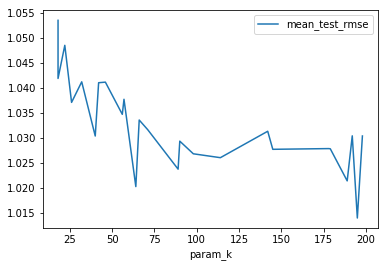

In [12]:
%matplotlib inline
sorted_df = knn_basic_results_df.sort_values(by=['param_k'])
sorted_df.plot(x='param_k', y='mean_test_rmse')

In [20]:
def flatten_arr_of_dict(params):
    return {key: [params[i][key] for i in range(len(params))] for key in params[0].keys()}

NameError: name 'shor' is not defined

In [25]:
bsl_options_arr = flatten_arr_of_dict(knn_basic_results_df['param_bsl_options'])
bsl_options_df = pd.DataFrame.from_dict(bsl_options_arr)
bsl_options_df.head()

,method,n_epochs,reg_i,reg_u
0,als,11,9,16
1,als,13,11,13
2,als,11,11,13
3,als,12,10,13
4,als,13,9,13


In [28]:
sim_options_arr = flatten_arr_of_dict(knn_basic_results_df['param_sim_options'])
sim_options_df = pd.DataFrame.from_dict(sim_options_arr)
sim_options_df.head()
concat_df = pd.concat([knn_basic_results_df, bsl_options_df, sim_options_df], axis=1)

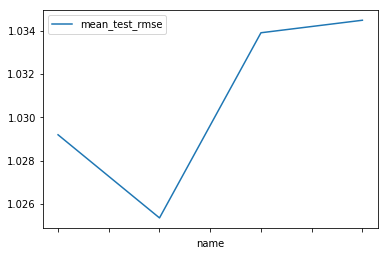

In [35]:
sorted_df = concat_df.groupby(by='name').mean()
sorted_df.plot(y='mean_test_rmse')

In [36]:
sorted_df.head()

,mean_fit_time,mean_test_rmse,mean_test_time,param_k,param_min_k,rank_test_rmse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,...,split9_test_rmse,std_fit_time,std_test_rmse,std_test_time,n_epochs,reg_i,reg_u,user_based,min_support,shrinkage
name,,,,,,,,,,,,,,,,,,,,,
cosine,328.709596,1.029196,363.876017,119.000000,5.000000,9.750000,1.030425,1.025181,1.030801,1.030466,...,1.032464,12.678655,0.002133,5.935888,13.250000,9.250000,14.000000,True,5.500000,50.000000
msd,150.252987,1.025358,337.117037,92.333333,7.333333,8.666667,1.026611,1.021198,1.026750,1.025995,...,1.028814,3.007325,0.002102,7.643086,11.666667,10.000000,15.333333,True,4.000000,66.666667
pearson,404.421948,1.033906,343.388349,119.428571,4.857143,14.857143,1.035183,1.030541,1.035713,1.034771,...,1.037765,13.540244,0.002063,10.670397,12.571429,9.857143,15.571429,True,6.142857,42.857143
pearson_baseline,329.100332,1.034484,322.262860,70.727273,6.090909,14.181818,1.035983,1.030823,1.036043,1.035460,...,1.038282,10.277106,0.002173,6.796174,12.272727,9.636364,15.000000,True,4.272727,36.363636


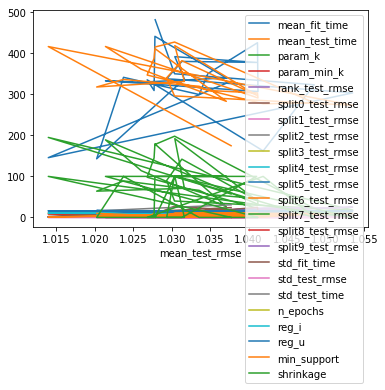

In [37]:
concat_df.plot(x='mean_test_rmse')

In [48]:
def group_by_key_and_sort(df, key):
    return df.groupby(by=key)[key].agg(['mean', 'std'])

In [56]:
import matplotlib.pyplot as plt
grouped_df = concat_df.groupby(by='param_min_k')['mean_test_rmse'].agg(['mean', 'std'])
#group_by_key_and_sort(concat_df, 'param_min_k').plot(y='mean_test_rmse', x='param_min_k')
grouped_df

,mean,std
param_min_k,,
1,1.031879,0.008275
2,1.034713,NaN
3,1.027816,NaN
4,1.031945,0.006370
5,1.047359,0.008759
6,1.024165,0.004988
7,1.030711,0.004048
8,1.033628,0.010038


In [61]:
grouped_df.xs(0)

KeyError: 0

In [70]:
def sort_and_plot(df, y_key, x_key):
    df.sort_values(x_key).plot(y=y_key, x=x_key)

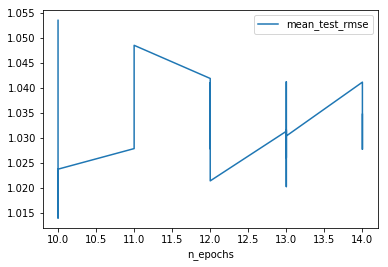

In [71]:
sort_and_plot(concat_df, 'mean_test_rmse', 'n_epochs')

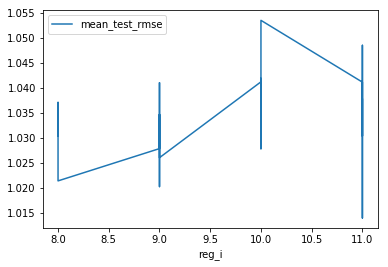

In [64]:
sort_and_plot(concat_df, 'mean_test_rmse', 'reg_i')

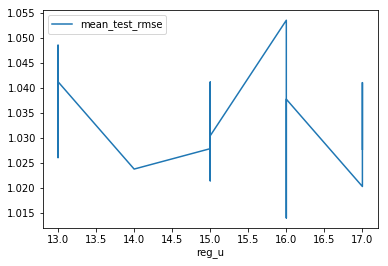

In [65]:
sort_and_plot(concat_df, 'mean_test_rmse', 'reg_u')

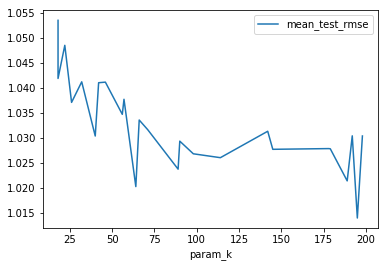

In [72]:
sort_and_plot(concat_df, 'mean_test_rmse', 'param_k')

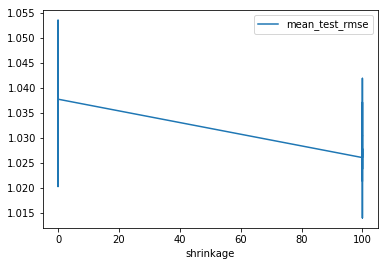

In [73]:
sort_and_plot(concat_df, 'mean_test_rmse', 'shrinkage')

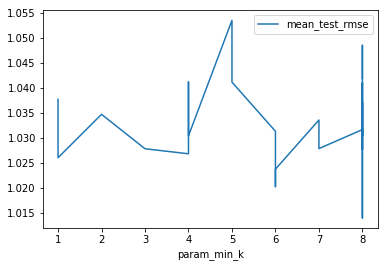

In [74]:
sort_and_plot(concat_df, 'mean_test_rmse', 'param_min_k')

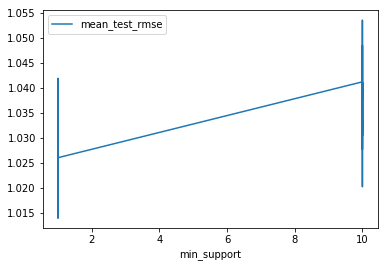

In [75]:
sort_and_plot(concat_df, 'mean_test_rmse', 'min_support')